In [1]:
from qgis.core import *
import pandas as pd
import numpy as np

In [2]:
import sys
import os
from osgeo import ogr
from qgis.core import (
     QgsApplication,
     QgsProcessingFeedback,
     QgsVectorLayer
)
from qgis.analysis import QgsNativeAlgorithms

In [3]:
QgsApplication.setPrefixPath(r'C:\OSGeo4W\apps\qgis', True)
qgs = QgsApplication([], False)
qgs.initQgis()
sys.path.append(r'C:\OSGeo4W\apps\qgis\python\plugins')

In [4]:
import geopandas as gpd
import matplotlib.pyplot as plt
plt.ion()
import xlwings as xw
import time

import processing
from processing.core.Processing import Processing
Processing.initialize()
QgsApplication.processingRegistry().addProvider(QgsNativeAlgorithms())
#for alg in QgsApplication.processingRegistry().algorithms():
#        print(alg.id(), "--->", alg.displayName())

C:\OSGeo4W\apps\Python39\lib\site-packages\pyproj\__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


False

In [5]:
# living_houses_pts = QgsVectorLayer(r"https://github.com/echo-golf-oscar-romeo/kindergarten_accessibility/blob/c66a8368b58ad126afb051cc72958379104b80fb/living_houses_pts.geojson")
# kindergarten_pts = QgsVectorLayer(r"https://github.com/echo-golf-oscar-romeo/kindergarten_accessibility/blob/5f8e3b92d19082e424ded1010d9ca836e44ba49c/kindergarten_pts.geojson")

living_houses_pts = QgsVectorLayer(r"C:\Users\egorb\Documents\ГП\2 курс\ПроектСем\3 module\PyModel\living_houses_pts.geojson")
kindergarten_pts = QgsVectorLayer(r"C:\Users\egorb\Documents\ГП\2 курс\ПроектСем\3 module\PyModel\kindergarten_pts.geojson")

In [6]:
from qgis.core import QgsProcessing
from qgis.core import QgsProcessingAlgorithm
from qgis.core import QgsProcessingMultiStepFeedback
from qgis.core import QgsProcessingParameterVectorLayer
from qgis.core import QgsProcessingParameterNumber
from qgis.core import QgsProcessingParameterFileDestination
from qgis.core import QgsProcessingParameterFeatureSink
import processing


class Kindergarten_egor(QgsProcessingAlgorithm):

    def initAlgorithm(self, config=None):
        self.addParameter(QgsProcessingParameterVectorLayer('livinghousescentoids', 'living_houses_centoids', types=[QgsProcessing.TypeVectorPoint], defaultValue=living_houses_pts))
        self.addParameter(QgsProcessingParameterVectorLayer('kindergartencentroids', 'kindergarten_centroids', types=[QgsProcessing.TypeVectorPoint], defaultValue=kindergarten_pts))
        self.addParameter(QgsProcessingParameterNumber('bufferradius', 'buffer_radius', type=QgsProcessingParameterNumber.Integer, minValue=1, defaultValue=300))
        self.addParameter(QgsProcessingParameterFileDestination('Spreadsheet', 'spreadsheet', fileFilter='Microsoft Excel (*.xlsx);;Open Document Spreadsheet (*.ods)', createByDefault=True, defaultValue=None))
        self.addParameter(QgsProcessingParameterFeatureSink('Intersection_raw', 'intersection_raw', optional=True, type=QgsProcessing.TypeVectorAnyGeometry, createByDefault=True, defaultValue=None))

    def processAlgorithm(self, parameters, context, model_feedback):
        # Use a multi-step feedback, so that individual child algorithm progress reports are adjusted for the
        # overall progress through the model
        feedback = QgsProcessingMultiStepFeedback(3, model_feedback)
        results = {}
        outputs = {}

        # Buffer
        alg_params = {
            'DISSOLVE': False,
            'DISTANCE': parameters['bufferradius'],
            'END_CAP_STYLE': 0,  # Round
            'INPUT': parameters['kindergartencentroids'],
            'JOIN_STYLE': 0,  # Round
            'MITER_LIMIT': 2,
            'SEGMENTS': 15,
            'OUTPUT': QgsProcessing.TEMPORARY_OUTPUT
        }
        outputs['Buffer'] = processing.run('native:buffer', alg_params, context=context, feedback=feedback, is_child_algorithm=True)

        feedback.setCurrentStep(1)
        if feedback.isCanceled():
            return {}

        # Join attributes by location
        alg_params = {
            'DISCARD_NONMATCHING': False,
            'INPUT': outputs['Buffer']['OUTPUT'],
            'JOIN': parameters['livinghousescentoids'],
            'JOIN_FIELDS': [''],
            'METHOD': 0,  # Create separate feature for each matching feature (one-to-many)
            'PREDICATE': [1],  # contains
            'PREFIX': 'j_',
            'OUTPUT': parameters['Intersection_raw']
        }
        outputs['JoinAttributesByLocation'] = processing.run('native:joinattributesbylocation', alg_params, context=context, feedback=feedback, is_child_algorithm=True)
        results['Intersection_raw'] = outputs['JoinAttributesByLocation']['OUTPUT']

        feedback.setCurrentStep(2)
        if feedback.isCanceled():
            return {}

        # Export to spreadsheet
        alg_params = {
            'FORMATTED_VALUES': False,
            'LAYERS': outputs['JoinAttributesByLocation']['OUTPUT'],
            'OVERWRITE': True,
            'USE_ALIAS': False,
            'OUTPUT': parameters['Spreadsheet']
        }
        outputs['ExportToSpreadsheet'] = processing.run('native:exporttospreadsheet', alg_params, context=context, feedback=feedback, is_child_algorithm=True)
        results['Spreadsheet'] = outputs['ExportToSpreadsheet']['OUTPUT']
        print(results['Spreadsheet'])
        return results

    def name(self):
        return 'kindergarten_egor'

    def displayName(self):
        return 'kindergarten_egor'

    def group(self):
        return 'egor'

    def groupId(self):
        return 'egor'

    def createInstance(self):
        return Kindergarten_egor()

C:\Users\egorb\Documents\ГП\2 курс\ПроектСем\3 module\PyModel\trash\trash_000200.xlsx
   houses id  Обеспеченность  Население
0          0        0.000000        431
1          1       59.549746        551
2          2       59.549746        468
3          3       59.549746        373
4          4       59.549746        374


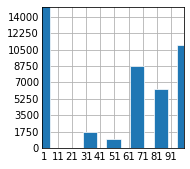

C:\Users\egorb\Documents\ГП\2 курс\ПроектСем\3 module\PyModel\trash\trash_000225.xlsx
   houses id  Обеспеченность  Население
0          0         0.00000        431
1          1        53.86513        551
2          2        53.86513        468
3          3        53.86513        373
4          4        53.86513        374


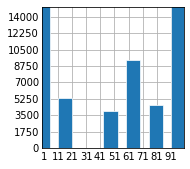

C:\Users\egorb\Documents\ГП\2 курс\ПроектСем\3 module\PyModel\trash\trash_000250.xlsx
   houses id  Обеспеченность  Население
0          0        0.000000        431
1          1       59.133837        551
2          2       58.554019        468
3          3       58.554019        373
4          4       59.133837        374


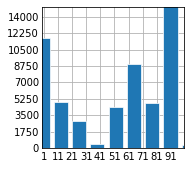

C:\Users\egorb\Documents\ГП\2 курс\ПроектСем\3 module\PyModel\trash\trash_000275.xlsx
   houses id  Обеспеченность  Население
0          0        0.000000        431
1          1       55.390368        551
2          2       54.009169        468
3          3       54.009169        373
4          4       54.009169        374


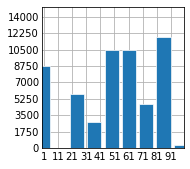

C:\Users\egorb\Documents\ГП\2 курс\ПроектСем\3 module\PyModel\trash\trash_000300.xlsx
   houses id  Обеспеченность  Население
0          0        0.000000        431
1          1       50.562867        551
2          2       54.303513        468
3          3       54.303513        373
4          4       54.303513        374


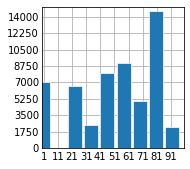

C:\Users\egorb\Documents\ГП\2 курс\ПроектСем\3 module\PyModel\trash\trash_000325.xlsx
   houses id  Обеспеченность  Население
0          0        0.000000        431
1          1       43.077884        551
2          2       49.645307        468
3          3       49.645307        373
4          4       49.645307        374


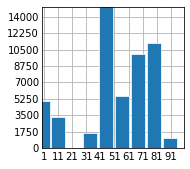

C:\Users\egorb\Documents\ГП\2 курс\ПроектСем\3 module\PyModel\trash\trash_000350.xlsx
   houses id  Обеспеченность  Население
0          0        0.000000        431
1          1       41.475451        551
2          2       48.846224        468
3          3       48.004946        373
4          4       48.846224        374


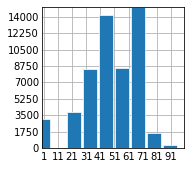

C:\Users\egorb\Documents\ГП\2 курс\ПроектСем\3 module\PyModel\trash\trash_000375.xlsx
   houses id  Обеспеченность  Население
0          0        0.000000        431
1          1       41.226017        551
2          2       47.050370        468
3          3       47.455206        373
4          4       47.050370        374


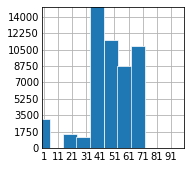

C:\Users\egorb\Documents\ГП\2 курс\ПроектСем\3 module\PyModel\trash\trash_000400.xlsx
   houses id  Обеспеченность  Население
0          0        0.000000        431
1          1       33.519377        551
2          2       44.236503        468
3          3       46.095511        373
4          4       44.236503        374


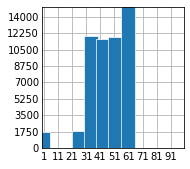

C:\Users\egorb\Documents\ГП\2 курс\ПроектСем\3 module\PyModel\trash\trash_000425.xlsx
   houses id  Обеспеченность  Население
0          0        0.000000        431
1          1       37.472770        551
2          2       45.328296        468
3          3       45.328296        373
4          4       46.363632        374


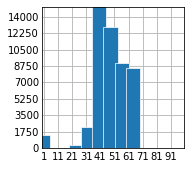

C:\Users\egorb\Documents\ГП\2 курс\ПроектСем\3 module\PyModel\trash\trash_000450.xlsx
   houses id  Обеспеченность  Население
0          0        0.000000        431
1          1       34.864641        551
2          2       44.186884        468
3          3       44.186884        373
4          4       45.186418        374


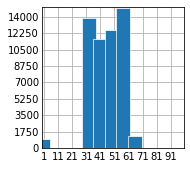

C:\Users\egorb\Documents\ГП\2 курс\ПроектСем\3 module\PyModel\trash\trash_000475.xlsx
   houses id  Обеспеченность  Население
0          0        0.000000        431
1          1       42.461364        551
2          2       41.947824        468
3          3       41.947824        373
4          4       46.603098        374


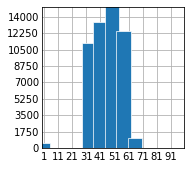

C:\Users\egorb\Documents\ГП\2 курс\ПроектСем\3 module\PyModel\trash\trash_000500.xlsx
   houses id  Обеспеченность  Население
0          0        0.000000        431
1          1       40.406279        551
2          2       40.074616        468
3          3       40.074616        373
4          4       45.687463        374


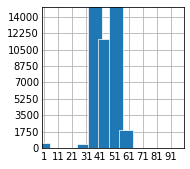

In [11]:
hello = Kindergarten_egor()
for buffer_radius in [200,225,250,275,300,325,350,375,400,425,450,475,500]:#[300,310,320,330,340,350,360,370,380,390,400,500]:
    intersection_raw = r"C:\Users\egorb\Documents\ГП\2 курс\ПроектСем\3 module\PyModel\trash\trash_000%s.geojson" % buffer_radius
    table = r"C:\Users\egorb\Documents\ГП\2 курс\ПроектСем\3 module\PyModel\trash\trash_000%s.xlsx" % buffer_radius
    parameters = {
        'bufferradius': buffer_radius,
        'kindergartencentroids': kindergarten_pts,
        'livinghousescentoids': living_houses_pts,
        'Intersection_raw': intersection_raw,
        'Spreadsheet': table
    }
    context = QgsProcessingContext()
    feedback = QgsProcessingFeedback()
    hello.processAlgorithm(parameters, context=context, model_feedback=feedback)
    
    # very bad moving data from excel to github excel file
    
    brand_new_data = pd.read_excel(r"C:\Users\egorb\Documents\ГП\2 курс\ПроектСем\3 module\PyModel\trash\trash_000%s.xlsx" % buffer_radius)
    #brand_new_data.to_excel(r"C:\Users\egorb\Documents\ГП\2 курс\ПроектСем\3 module\PyModel\Calculator.xlsx", sheet_name = 'intersection_raw')
    
    xb = xw.Book(r"C:\Users\egorb\Documents\ГП\2 курс\ПроектСем\3 module\PyModel\Calculator.xlsx")
    sheet = xb.sheets("intersection_raw")
    sheet.range("A1", "K1000").value = brand_new_data
    xb.save()
    
    time.sleep(0)
    
    data = pd.read_excel(r"C:\Users\egorb\Documents\ГП\2 курс\ПроектСем\3 module\PyModel\Calculator.xlsx", sheet_name = 'Bar_chart', engine="openpyxl")
    data_bar_chart = data[["Mean", "Population"]].loc[:8]
    print(data[["houses id", "Обеспеченность", "Население"]].head())
    
    plt.style.use('_mpl-gallery')
    x = data_bar_chart["Mean"]
    y = data_bar_chart["Population"]
    fig, ax = plt.subplots()
    ax.bar(x, y, width=10, edgecolor="white", linewidth=0.7)
    ax.set(xlim=(0, 100), xticks=np.arange(1, 100, 10), ylim=(0, 15000), yticks=np.arange(0, 15000, 1750))
    plt.savefig(r"C:\Users\egorb\Documents\ГП\2 курс\ПроектСем\3 module\PyModel\bar_charts\chart_%s" % buffer_radius)
    plt.show()